In [202]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import pandas as pd

import datetime as dt

from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [203]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [204]:
#Database Setup

#create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables from engine
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [205]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

#2010-01-01 is the first date in the dataset
first_date = session.query(Measurement.date).order_by(Measurement.date).first()
first_date

('2010-01-01')

In [206]:
#2017-08-23 is the last date in the dataset
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [207]:
# Perform a query to retrieve the data and precipitation scores
precipitation =(session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= '2016-08-23').all())

In [208]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data = pd.DataFrame(precipitation)
precipitation_data.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [209]:
# Sort the dataframe by date
precipitation_data.sort_values(by = 'date')
precipitation_data.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [210]:
precipitation_data.dtypes

date     object
prcp    float64
dtype: object

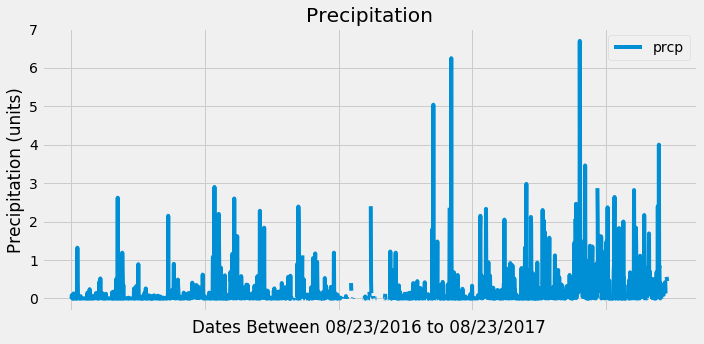

In [211]:
# Use Pandas Plotting with Matplotlib to plot the data
#Plot Style Set At Beginning

#Create a plot
fig1 = precipitation_data.plot(x = 'date', y = 'prcp',figsize = (10,5))
#Set labels etc.
fig1.set_title("Precipitation")
fig1.set_ylabel("Precipitation (units)")
fig1.set_xlabel("Dates Between 08/23/2016 to 08/23/2017")

plt.tight_layout()
#Save figure as a .png
fig = fig1.get_figure()
fig.savefig("precipitation.png")


In [212]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# STATIONS

In [213]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).group_by(Station.station).count()
print(f"There are {stations} unique stations available in this dataset.")


There are 9 unique stations available in this dataset.


In [214]:
#Get table names from hawaii.sqlite
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [215]:
#Get a list of column names from the station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [216]:
#Get a list of column names from the measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [217]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station,func.count(Measurement.station).\
              label('count')).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [218]:
# What station has the highest number of observations?
highest = station_activity.pop(0)
print(highest)
#USC00519281 has the highest number of observations

('USC00519281', 2772)


In [219]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#tobs is temperature observation data
session.query(func.max(Measurement.tobs),func.avg(Measurement.tobs),func.min(Measurement.tobs)).\
              filter(Measurement.station == 'USC00519281').all()

[(85.0, 71.66378066378067, 54.0)]

In [220]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures =(session.query(Measurement.date,Measurement.tobs).\
               filter(Measurement.station == 'USC00519281').\
               filter(Measurement.date >= '2016-08-23').all())
temperature_data = pd.DataFrame(temperatures)
temperature_data.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


In [221]:
temperature_data.count()

date    352
tobs    352
dtype: int64

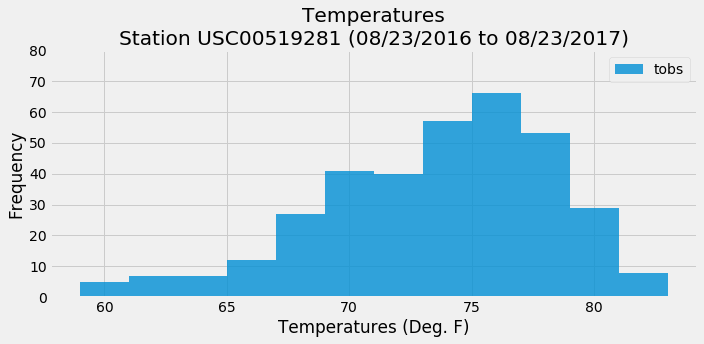

In [222]:
# Use Pandas Plotting with Matplotlib to plot a histogram
#Plot Style Set At Beginning

#Create a bar chart
fig2= temperature_data.plot(x = 'date', y = 'tobs',kind = 'hist',
                            bins = 12,figsize = (10,5),alpha = 0.8)
#Set labels etc.
fig2.set_title("Temperatures\nStation USC00519281 (08/23/2016 to 08/23/2017)")
fig2.set_ylabel("Frequency")
fig2.set_xlabel("Temperatures (Deg. F)")
#Set y ticks with start= 0, end = 90, stepsize = 10
fig2.set_yticks(np.arange(0,90,10))

plt.tight_layout()
#Save figure as a .png
fig = fig2.get_figure()
fig.savefig("temperature.png")


# Temperature Analysis (Optional)

In [223]:
#My vacation range wil be from 07/25 - 08/5 (July 25th through August 5th)

In [224]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [225]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_prediction = calc_temps('2016-07-25', '2016-08-05')
trip_prediction = list(np.ravel(trip_prediction))
trip_prediction

[72.0, 78.04054054054055, 83.0]

In [234]:
# Define tavg, tmax, tmin

tavg = trip_prediction[1]
tmin = trip_prediction[0]
tmax = trip_prediction[2]
variance = tmax - tmin

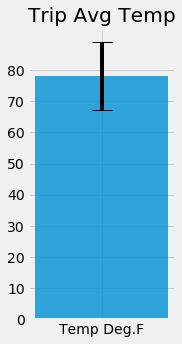

In [251]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

#create plot
fig3, ax = plt.subplots(figsize = (2.75,5))
ax.bar('Temp Deg.F',tavg, yerr = variance,
       capsize = 10, alpha = 0.8)
ax.set_yticks(np.arange(0,90,10))
ax.set_title("Trip Avg Temp")
plt.tight_layout()
#Save figure as a .png
fig = fig3.get_figure()
fig3.savefig("AvgTemp.png")

In [252]:
## Calculate the rainfall per weather station for your trip dates using
# the previous year's matching dates.
# Sort this in descending order by precipitation amount and list 
# the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [228]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [229]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [230]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [231]:
# Plot the daily normals as an area plot with `stacked=False`


# Step 2 - Climate App

In [232]:
#Reference climateapp.py